### Library Imports

In [1]:
import numpy as np
import pandas as pd
import scipy
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
df_seg = pd.read_csv('../Data/segmentation data.csv', index_col=0)

### Data Exploration

In [3]:
df_seg.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
ID,,,,,,,
100000001,0,0,67,2,124670,1,2
100000002,1,1,22,1,150773,1,2
100000003,0,0,49,1,89210,0,0
100000004,0,0,45,1,171565,1,1
100000005,0,0,53,1,149031,1,1


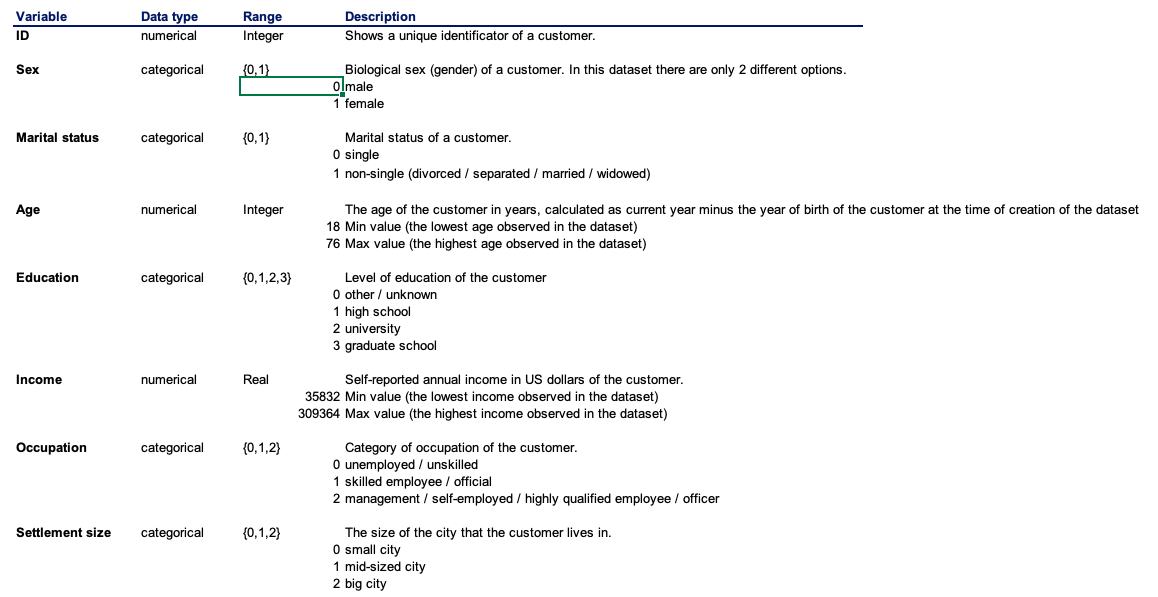

In [40]:
df_seg[['Age','Income']].describe()

,Age,Income
count,2000.000000,2000.000000
mean,35.909000,120954.419000
std,11.719402,38108.824679
min,18.000000,35832.000000
25%,27.000000,97663.250000
50%,33.000000,115548.500000
75%,42.000000,138072.250000
max,76.000000,309364.000000


### Visualization

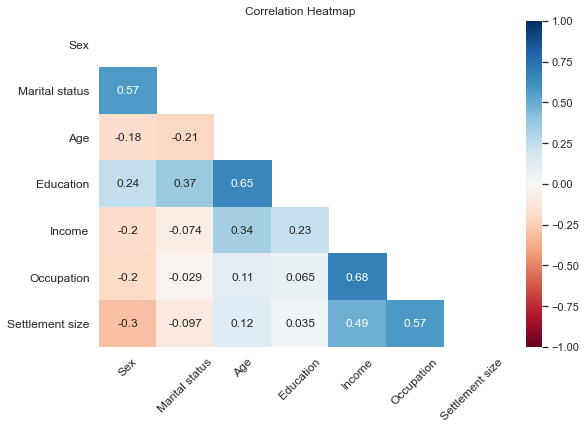

In [42]:
plt.figure(figsize=(9,6))

corr = df_seg.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

s = sns.heatmap(data=corr,
                mask=mask,
            annot=True,
            vmin = -1,
            vmax = 1,
            cmap = 'RdBu')
s.set_yticklabels(s.get_yticklabels(), rotation = 0, fontsize=12)
s.set_xticklabels(s.get_xticklabels(), rotation = 45, fontsize=12)
plt.title('Correlation Heatmap')
plt.show()

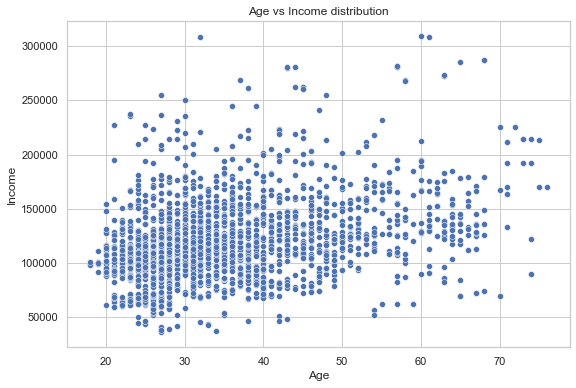

In [43]:
plt.figure(figsize=(9,6))
sns.set_style('whitegrid')
sns.scatterplot(x = df_seg['Age'],y = df_seg['Income'])
plt.title('Age vs Income distribution')
plt.show()

### Standardization

*Used standardization to scale the data to a similar min-max value*

In [7]:
scaler = StandardScaler()
df_seg_prep = scaler.fit_transform(df_seg)

## Clustering Methods
---
   ### Hierarchical

In [8]:
 hier_clust = linkage(df_seg_prep, method='ward')

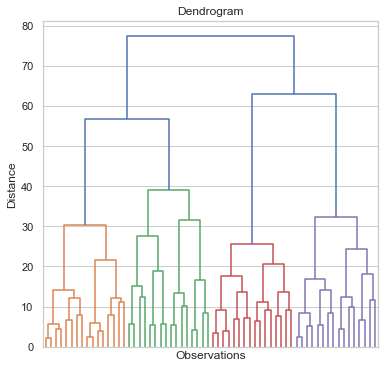

In [51]:
plt.figure(figsize=(6,6))
plt.title('Dendrogram')
plt.xlabel('Observations')
plt.ylabel('Distance')

dendrogram(hier_clust,
           truncate_mode='level',p=5,
          show_leaf_counts=False,
          no_labels=True)
plt.show()

1. *Hierarchical clustering is slow and may take hours if we have a large dataset.* 
2. *It almost always generates/predicts the number of clusters, we can use that number on flat clustering methods for big data.*    
3. ***In our case Recommended No. of Clusters = 4***
---
### K-means

In [44]:
wcss = []

# Checking for optiamal no. of clusters
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=10)
    kmeans.fit(df_seg_prep)
    wcss.append(kmeans.inertia_)

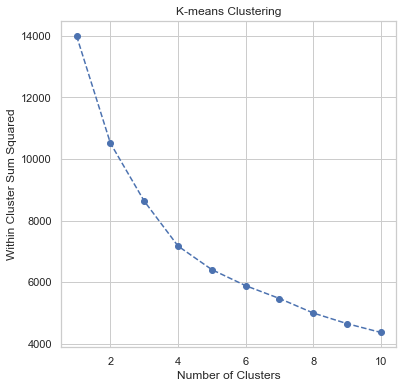

In [50]:
plt.figure(figsize=(6,6))
plt.title('K-means Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Within Cluster Sum Squared')
plt.plot(range(1,11), wcss, marker = 'o', linestyle = '--')
plt.show()

*From the plot above,
Number of clusters --> Find elbow curve. i.e Check where our curve smooths after a steep drop.*

***Based on our results from K-means and Hierarchical clustering, we select 4 clusters***

In [12]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=10)
kmeans.fit(df_seg_prep)

KMeans(n_clusters=4, random_state=10)

### K-means Results

In [13]:
seg_res = df_seg.copy()
seg_res['Segment'] = kmeans.labels_

In [47]:
df_analysis = seg_res.groupby(['Segment']).mean()

df_analysis

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Segment,,,,,,,
0,0.501901,0.692015,55.703422,2.129278,158338.422053,1.129278,1.110266
1,0.029825,0.173684,35.635088,0.733333,141218.249123,1.271930,1.522807
2,0.853901,0.997163,28.963121,1.068085,105759.119149,0.634043,0.422695
3,0.352814,0.019481,35.577922,0.746753,97859.852814,0.329004,0.043290


***From the above Table, we name Segments as follows:***

0. *Well off*
1. *Career Focused*
2. *Standard*
3. *Few Opportunities*

In [15]:
df_analysis['n_obs'] = seg_res[['Segment','Sex']].groupby(['Segment']).count()
df_analysis['prop'] = df_analysis['n_obs'] / df_analysis['n_obs'].sum() 

In [16]:
df_analysis.rename({0:'Well-off',1:'Career Focused',2:'Standard',3:'Fewer Opportunities'})

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,n_obs,prop
Segment,,,,,,,,,
Well-off,0.501901,0.692015,55.703422,2.129278,158338.422053,1.129278,1.110266,263,0.1315
Career Focused,0.029825,0.173684,35.635088,0.733333,141218.249123,1.271930,1.522807,570,0.2850
Standard,0.853901,0.997163,28.963121,1.068085,105759.119149,0.634043,0.422695,705,0.3525
Fewer Opportunities,0.352814,0.019481,35.577922,0.746753,97859.852814,0.329004,0.043290,462,0.2310


In [17]:
seg_res['labels'] = seg_res['Segment'].map({0:'Well-off',1:'Career Focused',2:'Standard',3:'Fewer Opportunities'})

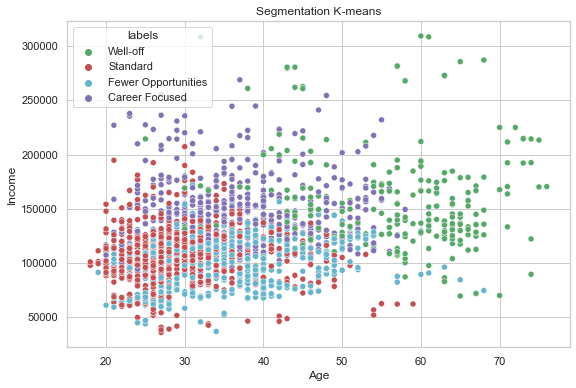

In [49]:
x_axis = seg_res['Age']
y_axis = seg_res['Income']

plt.figure(figsize=(9,6))
sns.scatterplot(x=x_axis,y=y_axis, hue=seg_res['labels'],
               palette=['g','r','c','m'])
plt.title('Segmentation K-means')
plt.show()

***Output***

1. *Well off are better segmented, but the other groups overlap.*
2. *K-means did a reasonable job at segmentation however the result is far from perfect.*

### Dimensionality Reduction using PCA

In [53]:
pca = PCA()
pca.fit(df_seg_prep)

PCA()

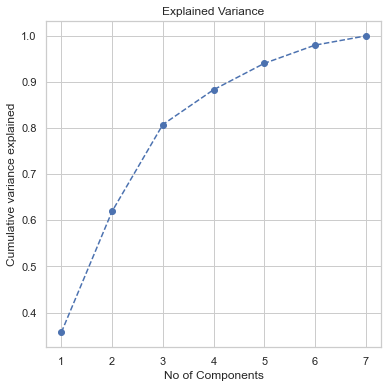

In [54]:
plt.figure(figsize=(6,6))
plt.plot(range(1,8), pca.explained_variance_ratio_.cumsum(),
        marker ='o', linestyle='--')
plt.title('Explained Variance')
plt.xlabel('No of Components')
plt.ylabel('Cumulative variance explained')
plt.show()

In [21]:
pca = PCA(n_components=4)
pca.fit(df_seg_prep)

PCA(n_components=4)

### PCA Results

In [22]:
df_pca_comp = pd.DataFrame(data = pca.components_,
                          columns=df_seg.columns.values,
                          index=['Component 1','Component 2',
                                'Component 3', 'Component 4'])

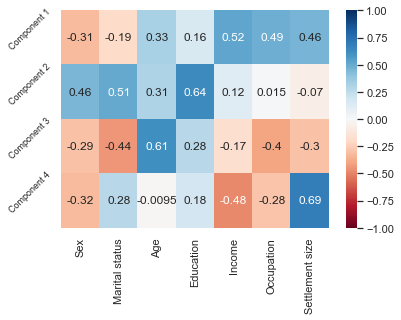

In [23]:
sns.heatmap(df_pca_comp,
           vmin=-1, vmax=1,
           cmap='RdBu',
           annot=True)
plt.yticks([0,1,2,3], 
          ['Component 1','Component 2','Component 3', 'Component 4'],
          rotation =45, 
          fontsize =9)
plt.show()

***Output***

1. ***Component 1*** - *Career Focused*
2. ***Component 2*** - *Education & Lifestyle*
3. ***Component 3*** - *Experience*
4. ***Component 4*** - *Big city*

In [24]:
scores_pca = pca.transform(df_seg_prep)

## K-means clustering using PCA

In [25]:
wcss = []

for i in range(1,11):
    kmeans_pca = KMeans(n_clusters=i, init='k-means++', random_state=10)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

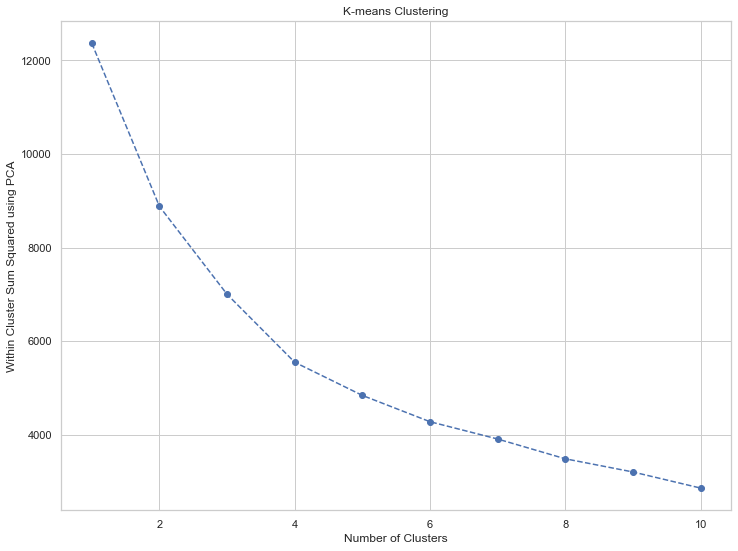

In [26]:
plt.figure(figsize=(9,6))
plt.title('K-means Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Within Cluster Sum Squared using PCA')
plt.plot(range(1,11), wcss, marker = 'o', linestyle = '--')
plt.show()

*From the plot above,
To select the number of clusters for K-means clustering, we select the elbow of the graph. i.e Check where our curve smooths after a steep drop. (4 clusters)*

In [27]:
kmeans_pca = KMeans(n_clusters=4, init='k-means++', random_state=10)
kmeans_pca.fit(scores_pca)

KMeans(n_clusters=4, random_state=10)

### PCA+K-Means Results

In [28]:
seg_res_pca = pd.concat([df_seg.reset_index(drop=True),
                       pd.DataFrame(scores_pca)], axis=1)
seg_res_pca.columns.values[-4:] = ['Component 1','Component 2',
                                'Component 3', 'Component 4']
seg_res_pca['Segment'] = kmeans_pca.labels_

In [29]:
seg_res_pca.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Component 1,Component 2,Component 3,Component 4,Segment
0,0,0,67,2,124670,1,2,2.514746,0.834122,2.174806,1.217794,2
1,1,1,22,1,150773,1,2,0.344935,0.598146,-2.211603,0.548385,1
2,0,0,49,1,89210,0,0,-0.651063,-0.680093,2.280419,0.120675,3
3,0,0,45,1,171565,1,1,1.714316,-0.579927,0.730731,-0.510753,0
4,0,0,53,1,149031,1,1,1.626745,-0.440496,1.244909,-0.231808,0


In [30]:
seg_res_pca_freq = seg_res_pca.groupby(['Segment']).mean()
seg_res_pca_freq[['Component 1','Component 2','Component 3','Component 4']]

,Component 1,Component 2,Component 3,Component 4
Segment,,,,
0,1.369400,-1.037857,-0.277835,0.218749
1,-1.131044,0.740540,-0.797914,-0.027451
2,1.697646,2.029427,0.841953,0.093869
3,-0.987777,-0.882022,0.965476,-0.271684


***Segments***

0. *Career Focused*
1. *Standard*
2. *Well off* 
3. *Fewer Opportunities*

In [31]:
seg_res_pca_freq['n_obs'] = seg_res_pca[['Segment','Age']].groupby(['Segment']).count()
seg_res_pca_freq['prop'] = seg_res_pca_freq['n_obs'] / seg_res_pca_freq['n_obs'].sum() 

In [57]:
seg_res_pca_freq.rename({0:'Career Focused',1:'Standard',
                    2:'Well-off',3:'Fewer Opportunities'})

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Component 1,Component 2,Component 3,Component 4,n_obs,prop
Segment,,,,,,,,,,,,,
Career Focused,0.025952,0.185121,35.550173,0.737024,140737.435986,1.262976,1.517301,1.369400,-1.037857,-0.277835,0.218749,578,0.2890
Standard,0.911809,0.986547,28.887892,1.064275,107510.721973,0.671151,0.433483,-1.131044,0.740540,-0.797914,-0.027451,669,0.3345
Well-off,0.503788,0.689394,55.689394,2.128788,158209.094697,1.125000,1.106061,1.697646,2.029427,0.841953,0.093869,264,0.1320
Fewer Opportunities,0.319018,0.089980,35.259714,0.768916,95850.155419,0.296524,0.038855,-0.987777,-0.882022,0.965476,-0.271684,489,0.2445


In [58]:
seg_res_pca['labels'] = seg_res_pca['Segment'].map({3:'Fewer Opportunities',1:'Standard',
                    0:'Career Focused',2:'Well-off'})

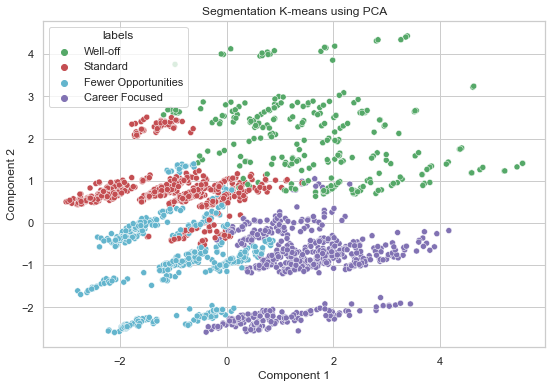

In [59]:
x_axis = seg_res_pca['Component 1']
y_axis = seg_res_pca['Component 2']

plt.figure(figsize=(9,6))
sns.scatterplot(x=x_axis,y=y_axis, hue=seg_res_pca['labels'],
               palette=['g','r','c','m'])
plt.title('Segmentation K-means using PCA')
plt.show()

***Output***

*K-means using PCA did a better job at segmentation however not perfect.*

## Export Model

In [36]:
pickle.dump(scaler, open('../Model/scaler.pickle','wb'))

In [37]:
pickle.dump(pca, open('../Model/pca.pickle','wb'))

In [38]:
pickle.dump(kmeans_pca, open('../Model/kmeans_pca.pickle','wb'))